In [1]:
from glotaran_tools.specification_parser import parse_yml
from glotaran_core.model import Dataset
from glotaran_models.kinetic import KineticSeparableModel
import numpy as np
from lmfit import Parameters
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib notebook

fitspec = '''
type: kinetic

parameter: {}

compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]
    - label: mc2
      k_matrices: [k2]

k_matrices:
  - label: "k1"
    matrix: {{
      '("s1","s1")': 1,
      '("s2","s2")': 2,
}}
  - label: "k2"
    matrix: {{
      '("s3","s3")': 3,
}}

initial_concentrations: []

irf: []

datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1, mc2]
    path: 'data/dataset1.ascii'

'''

In [2]:
test_parameter = [101e-4, 202e-5, 505e-6]
test_amps = [1,2,3]
times = np.asarray(np.arange(0, 1500, 1.5))
simparams = Parameters()
simparams.add("p1", 101e-3)
simparams.add("p2", 202e-4)
simparams.add("p3", 505e-5)

simparams.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1     0.101     -inf      inf     None     True     None
p2    0.0202     -inf      inf     None     True     None
p3   0.00505     -inf      inf     None     True     None


In [3]:
model = parse_yml(fitspec.format(test_parameter))
print(model)

Modeltype: Kinetic

Parameter
---------

Index: 1 Initial Value: 0.0101 Label: None
Index: 2 Initial Value: 0.00202 Label: None
Index: 3 Initial Value: 0.000505 Label: None

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']
Label: mc2
K-Matrices: ['k2']

Datasets
--------

Dataset 'dataset1'

	Dataset Scaling: None
	Initial Concentration: None
	Megacomplexes: ['mc1', 'mc2']

	Irf: None


K-Matrices
----------

Label: k2
Matrix:
[[3]]
Label: k1
Matrix:
[[1 0]
 [0 2]]


IRFs
----




In [4]:
fitmodel = KineticSeparableModel(model)
fitmodel.get_initial_fitting_parameter().pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1    0.0101     -inf      inf     None     True     None
p2   0.00202     -inf      inf     None     True     None
p3  0.000505     -inf      inf     None     True     None


(1000, 1)


<IPython.core.display.Javascript object>


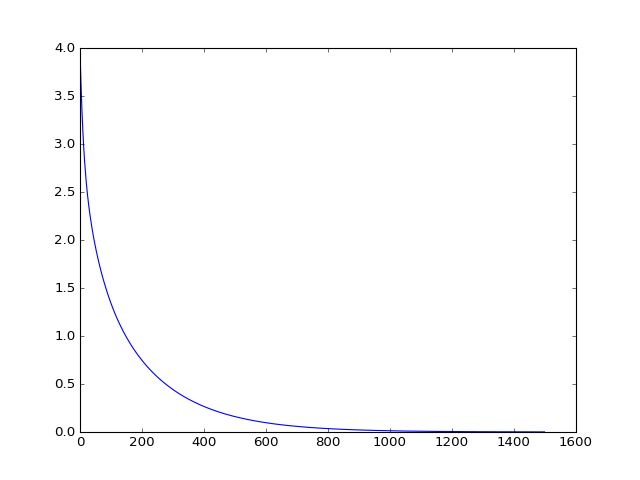

In [7]:
data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1',
                                           'dataset1_x': [0],
                                            })
fig = plt.figure()
plt.plot(times, data[:, 0])

In [9]:
result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), 
                      *times, 
                      **{"dataset1": data}
                     )
result.best_fit_parameter.pretty_print()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.8880e+01                                    1.31e+05    
       1              2         8.3666e+00      8.05e+01       6.69e-03       1.85e+04    
       2              4         3.0153e+00      5.35e+00       2.58e-03       1.21e+03    
       3              5         1.6447e+00      1.37e+00       5.16e-03       7.36e+02    
       4              6         1.0454e+00      5.99e-01       1.03e-02       5.57e+02    
       5              7         4.0870e-01      6.37e-01       8.73e-03       3.23e+02    
       6             10         3.2305e-01      8.56e-02       5.80e-04       5.61e+01    
       7             11         2.8416e-01      3.89e-02       5.80e-04       6.17e+01    
       8             12         2.2631e-01      5.79e-02       1.16e-03       1.96e+01    
       9             13         1.8078e-01      4.55e-02       2.32e-03       1.59e+01    

<IPython.core.display.Javascript object>


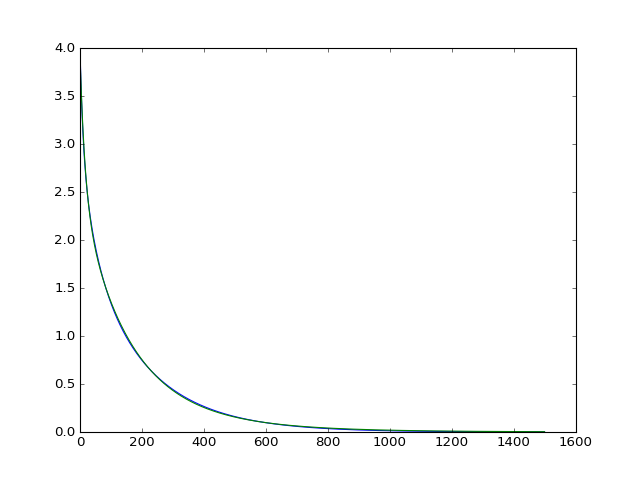

In [11]:
reconstructed_data = result.eval(*times, **{"dataset1": data})
fig = plt.figure()
plt.plot(times, data[:, 0])
plt.plot(times, reconstructed_data[:, 0])